# 日常导入

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# 导入的程序在下面
1. 导入一些我们定义的提升效率的函数
2. 导入一些我们需要的库，之后就不用再导入了
3. 矩阵乘法我们实现之后就用pytorch里面的代替了

In [3]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

测试一下效果怎么样

In [6]:
test_eq(TEST,'test')

# 获取数据

In [7]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [9]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/home/shaobowang/.fastai/data/mnist.pkl.gz')

In [10]:
with gzip.open(path,'rb') as f:
    ((x_train,y_train),(x_valid,y_valid),_) = pickle.load(f,encoding='latin-1')

我们成功解压下载了软件，利用gzip打开文件，注意一般情况下使用latin-1编码会比较好
我们不给用numpy数组，所以需要转换为tensor

In [12]:
x_train,y_train,x_valid,y_valid = map(tensor,(x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape,y_train,y_train.shape,y_train.min(),y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

做一些简单的测试

In [14]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [15]:
mpl.rcParams['image.cmap']='gray'

In [16]:
img = x_train[0]

In [17]:
img.view(28,28).type() #转换维度为2维

'torch.FloatTensor'

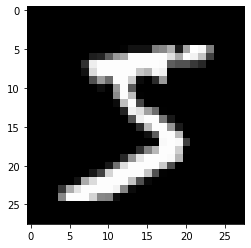

In [18]:
plt.imshow(img.view(28,28))

# 进入正题

In [19]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

# 矩阵乘法

## 3-loop 版本

In [21]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [22]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

### 测一下时间

In [23]:
%time t1 = matmul(m1,m2)

CPU times: user 513 ms, sys: 0 ns, total: 513 ms
Wall time: 512 ms


In [24]:
len(x_train)

50000

## 利用elementwise操作来加速 2-loop版本

In [25]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [26]:
%timeit -n 10 _=matmul(m1,m2)

670 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


快了很多，还能再快吗？

## 定义一个test_near

In [28]:
# export
def near(a,b):
    return torch.allclose(a,b,rtol=1e-3,atol=1e-5)
def test_near(a,b):
    test(a,b,near)

In [29]:
test_near(t1,matmul(m1,m2)) #和第一次的乘积比较检测正确性

# 利用广播机制再加速 1-loop
## unsqueeze 可以让你加一个维度在某一个方向
## 利用None可以等效于unsqueeze效果
另外，可以用...来省略之前的维度，直接写出最后一个维度
c.shape,c.unsqueeze(0).shape,c.unsqueeze(1).shape

c.shape,c[None,:].shape,c[:,None].shape

这些是一样的


In [30]:
c = tensor([10.,20,30]);c

tensor([10., 20., 30.])

In [33]:
m = tensor([[1.,2,3],[4,5,6],[7,8,9]]);m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [34]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [35]:
m+c #每一行都加上了

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [36]:
c.unsqueeze(0) #横向增加了一个维度,在0

tensor([[10., 20., 30.]])

In [37]:
c.unsqueeze(1) #纵向增加了一个维度，在1

tensor([[10.],
        [20.],
        [30.]])

In [38]:
c.shape,c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [39]:
c.shape,c[None,:].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

## 1-loop 版本

In [40]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1)*b).sum(0)
        # c[i] (bc)
        # a[i] (ac,1)*(br,bc) 注意这里是点乘，所以ac=br就很ok，
        # broadcasting让(ac,1)->(ac,bc)
    return c

In [41]:
test_near(matmul(m1,m2),t1)

In [42]:
%timeit -n 10 _=matmul(m1,m2)

137 µs ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 0-loop 版本？爱因斯坦乘积

In [43]:
def matmul(a,b):
    return torch.einsum('ik,kj->ij',a,b)

In [44]:
test_near(matmul(m1,m2),t1)

In [45]:
%timeit -n 10 _=matmul(m1,m2)

109 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# pytorch中做的事情

In [48]:
%timeit -n 10 t2=m1.matmul(m2)

71.4 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
t2 = m1@m2

In [50]:
test_near(t1,t2)

In [51]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

# 最后导出一下我们的成果

In [52]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
